# Deep Learning Augmented Model Training with Hyperparameter Tuning

## This notebooks contains the experiment conducted of augmenting the GLENDA dataset and then applying hyperparameter tuning

##### pip install keras-tuner

In [ ]:
import gc
del X  # Delete large variables
gc.collect()  # Free memory

In [1]:
## Imports
import os
import shutil
import uuid
import cv2
import warnings
import keras
import time
import numpy as np
import pandas as pd
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns

## Tensorflow Imports
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large, NASNetMobile, EfficientNetB0, EfficientNetV2B0, ConvNeXtTiny, DenseNet121, ResNet50V2, ConvNeXtSmall, ConvNeXtSmall, ConvNeXtBase, InceptionV3, Xception, InceptionResNetV2, VGG16 
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Input
from tensorflow.keras import backend as K

## Sklearn Imports
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, classification_report, precision_recall_curve, ConfusionMatrixDisplay

warnings.filterwarnings("ignore")

In [2]:
# Try with 2000 samples from each class
X = []
y = []
classes = ['no_pathology_train', 'pathology_train']
base_path = 'C:/Users/vella/Mastes Thesis/processed_data/'

# Define Data Augmentation Generator
datagen = ImageDataGenerator(
    rotation_range=30,  # Rotate images randomly
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in/out
    horizontal_flip=True,  # Flip images horizontally
    brightness_range=[0.8, 1.2],  # Adjust brightness
    fill_mode='nearest'  # Fill in missing pixels
)

# Convert images into numpy arrays and apply augmentation
for i, target in enumerate(classes):
    files = base_path + target + '/'

    for file in os.listdir(files):
        # Load the image
        img = image.load_img(files + file)
        
        # Convert it to an array
        img_array = image.img_to_array(img, dtype='uint8')

        # Resize to 224x224
        img_array = cv2.resize(img_array, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

        # Reshape for augmentation (ImageDataGenerator expects shape (1, height, width, channels))
        img_array = np.expand_dims(img_array, axis=0)

        # Apply augmentation (Generate 1 augmented version per image) 
        #more than 1 image and will give an error
        #MemoryError: Unable to allocate 43.2 GiB for an array with shape (77046, 224, 224, 3) and data type float32
        augmented_image = datagen.flow(img_array, batch_size=1).next()[0]  # Extract augmented image

        # Append original & augmented image to X
        X.append(img_array[0])  # Original image
        X.append(augmented_image)  # Augmented image

        # Append the target to y (Twice, for original & augmented)
        y.append(target)
        y.append(target)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Encode labels
y_dict = {'no_pathology_train': 0, 'pathology_train': 1}
y = np.vectorize(y_dict.get)(y)

print(f"Dataset size after augmentation: {X.shape}, Labels: {y.shape}")

Dataset size after augmentation: (51364, 224, 224, 3), Labels: (51364,)


In [3]:
# shuffle the data
shuffler = np.random.permutation(len(X))
X = X[shuffler]
y = y[shuffler]

X.shape, y.shape
# y

((51364, 224, 224, 3), (51364,))

In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
# X_train.shape,y_train.shape,X_test.shape,y_test.shape

# convert to binary
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train.shape, y_test.shape

X_train.shape,y_train.shape,X_test.shape,y_test.shape

((41091, 224, 224, 3), (41091, 2), (10273, 224, 224, 3), (10273, 2))

In [5]:
# For results
model_results = pd.DataFrame({'Metrics':['Accuracy', 'Precision', 'Recall', 'F1Score', 'ROC AUC']})
model_results.head()

,Metrics
0,Accuracy
1,Precision
2,Recall
3,F1Score
4,ROC AUC


In [6]:
## evaluation functions 

def evaluate(ytest, ypred, xtrain, ytrain):
    
    accuracy = accuracy_score(ytest, ypred)
    precision = precision_score(ytest, ypred)
    recall = recall_score(ytest, ypred)
    f1score = f1_score(ytest, ypred)
    auc = roc_auc_score(ytest, ypred)
    conf_matrix = confusion_matrix(ytest, ypred)
    
    print("\n--------------- Evaluation ---------------")
    print(f'Accuracy: {accuracy:.3}')
    print(f'Precision: {precision:.3}')
    print(f'Recall: {recall:.3}')
    print(f'F1 Score: {f1score:.3}')
    print(f'ROC AUC: {auc:.3}')
    print(f'\nClassification Report: ')
    print(classification_report(ytest, ypred, target_names=['0 -  Negative (No Pathology)', '1 - Positive (Pathology)']))
    #print(f'\nConfusion Matrix: \n {conf_matrix}')
    print("\n--------------- Visual Evaluation ---------------")
    disp = ConfusionMatrixDisplay.from_predictions(ytest, ypred, cmap = 'cool')
    #disp.plot()
    fig = disp.figure_
    fig.set_figwidth(14)
    fig.set_figheight(5) 
    fig.suptitle('Confusion Matrix', fontsize = 15)
    plt.show()
        
    return accuracy, precision, recall, f1score, auc

In [7]:
def plot_curves(model_title, history):
    # Curve plots
    plt.figure(figsize=(12, 6))

    # Accuracy curve plot
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')  
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss curve plot
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')  
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


    # Main title for the entire figure
    plt.suptitle(f"{model_title} Accuracy and Loss Curve Plot", fontsize=16)
    
    # Show the plots
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  
    plt.show()

In [8]:
classes = ['no_pathology_train', 'pathology_train']  # Update this based on your dataset


def build_model(hp, model_name):  # Hyperparameter object
    K.clear_session()

    # Load Pretrained Base Model
    init_model = model_name(include_top=False, weights="imagenet", pooling='avg',
                                  input_tensor=Input(shape=(224, 224, 3)))

    # Freeze Pretrained Weights
    init_model.trainable = False

    # Define Model
    model = Sequential()
    model.add(init_model)

    # **Tune the number of neurons in the Dense layer**
    units = hp.Int('units', min_value=64, max_value=256, step=64)
    model.add(Dense(units, activation='relu'))

    # **Tune the dropout rate**
    dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(dropout))

    model.add(Dense(len(classes), activation='softmax'))

    # **Tune the learning rate and optimizer**
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Choice('lr', [0.0001, 0.001, 0.01])

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    # Compile Model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


## MobileNetV3 Small 

In [9]:
# Define Tuner
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, MobileNetV3Small),
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times each model is trained
    directory='tuning_results',  
    project_name='hyperparameter_tuning'
)

# Stop early if no improvement in 3 epochs
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[callback])

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: units={best_hps.get('units')}, dropout={best_hps.get('dropout')}, "
      f"optimizer={best_hps.get('optimizer')}, learning rate={best_hps.get('lr')}")

Reloading Tuner from tuning_results\hyperparameter_tuning\tuner0.json
Best Hyperparameters: units=64, dropout=0.2, optimizer=adam, learning rate=0.001


Epoch 1/20
899/899 [==============================] - 296s 314ms/step - loss: 0.1692 - accuracy: 0.9332 - val_loss: 0.0707 - val_accuracy: 0.9800
Epoch 2/20
899/899 [==============================] - 238s 264ms/step - loss: 0.0630 - accuracy: 0.9785 - val_loss: 0.0386 - val_accuracy: 0.9890
Epoch 3/20
899/899 [==============================] - 225s 250ms/step - loss: 0.0414 - accuracy: 0.9859 - val_loss: 0.0328 - val_accuracy: 0.9893
Epoch 4/20
899/899 [==============================] - 224s 249ms/step - loss: 0.0341 - accuracy: 0.9882 - val_loss: 0.0287 - val_accuracy: 0.9912
Epoch 5/20
899/899 [==============================] - 234s 261ms/step - loss: 0.0255 - accuracy: 0.9909 - val_loss: 0.0175 - val_accuracy: 0.9942
Epoch 6/20
899/899 [==============================] - 220s 245ms/step - loss: 0.0230 - accuracy: 0.9920 - val_loss: 0.0170 - val_accuracy: 0.9952
Epoch 7/20
899/899 [==============================] - 224s 250ms/step - loss: 0.0173 - accuracy: 0.9940 - val_loss: 0.0173 -

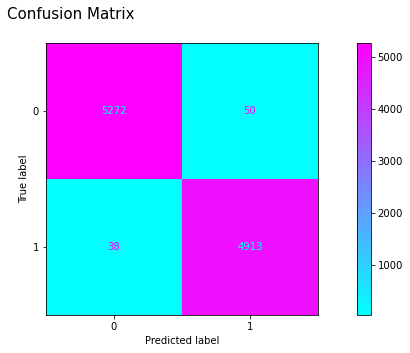

In [10]:
# Build Model with Best Hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train Model
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[callback])

# Evaluate Model on Test Data
pred = best_model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['MobileNetV3 Small'] = results

## MobileNetV3 Large 

In [11]:
# Define Tuner
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, MobileNetV3Large),
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times each model is trained
    directory='tuning_results',  
    project_name='hyperparameter_tuning'
)

# Stop early if no improvement in 3 epochs
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[callback])

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: units={best_hps.get('units')}, dropout={best_hps.get('dropout')}, "
      f"optimizer={best_hps.get('optimizer')}, learning rate={best_hps.get('lr')}")

Reloading Tuner from tuning_results\hyperparameter_tuning\tuner0.json
Best Hyperparameters: units=64, dropout=0.2, optimizer=adam, learning rate=0.001


Epoch 1/20
899/899 [==============================] - 511s 565ms/step - loss: 0.1070 - accuracy: 0.9594 - val_loss: 0.0323 - val_accuracy: 0.9903
Epoch 2/20
899/899 [==============================] - 485s 540ms/step - loss: 0.0317 - accuracy: 0.9899 - val_loss: 0.0211 - val_accuracy: 0.9924
Epoch 3/20
899/899 [==============================] - 493s 549ms/step - loss: 0.0199 - accuracy: 0.9932 - val_loss: 0.0146 - val_accuracy: 0.9953
Epoch 4/20
899/899 [==============================] - 493s 548ms/step - loss: 0.0154 - accuracy: 0.9947 - val_loss: 0.0115 - val_accuracy: 0.9969
Epoch 5/20
899/899 [==============================] - 495s 551ms/step - loss: 0.0111 - accuracy: 0.9961 - val_loss: 0.0102 - val_accuracy: 0.9963
Epoch 6/20
899/899 [==============================] - 498s 554ms/step - loss: 0.0104 - accuracy: 0.9969 - val_loss: 0.0092 - val_accuracy: 0.9971
Epoch 7/20
899/899 [==============================] - 496s 551ms/step - loss: 0.0111 - accuracy: 0.9958 - val_loss: 0.0085 -

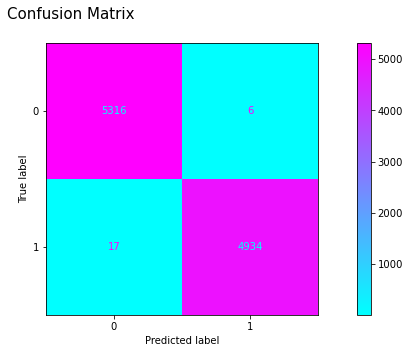

In [12]:
# Build Model with Best Hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train Model
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[callback])

# Evaluate Model on Test Data
pred = best_model.predict(X_test)
y_pred = np.argmax(pred, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['MobileNetV3 Large'] = results


--------------- Evaluation ---------------
Accuracy: 0.998
Precision: 0.999
Recall: 0.997
F1 Score: 0.998
ROC AUC: 0.998

Classification Report: 
                              precision    recall  f1-score   support

0 -  Negative (No Pathology)       1.00      1.00      1.00      5322
    1 - Positive (Pathology)       1.00      1.00      1.00      4951

                    accuracy                           1.00     10273
                   macro avg       1.00      1.00      1.00     10273
                weighted avg       1.00      1.00      1.00     10273


--------------- Visual Evaluation ---------------


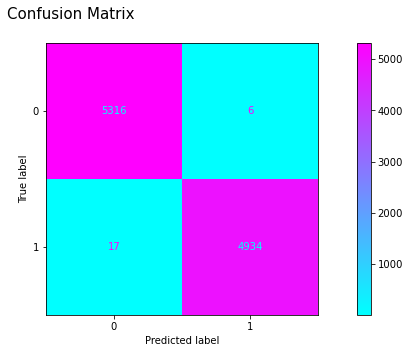

In [13]:
results = evaluate(y_test, y_pred, X_train, y_train)
model_results['MobileNetV3 Large'] = results

##  NASNetMobile

In [ ]:
# Define Tuner
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, NASNetMobile),
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times each model is trained
    directory='tuning_results',  
    project_name='hyperparameter_tuning'
)

# Stop early if no improvement in 3 epochs
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[callback])

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: units={best_hps.get('units')}, dropout={best_hps.get('dropout')}, "
      f"optimizer={best_hps.get('optimizer')}, learning rate={best_hps.get('lr')}")

In [ ]:
# Build Model with Best Hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train Model
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[callback])

# Evaluate Model on Test Data
pred = best_model.predict(X_test)
y_pred = np.argmax(pred, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['NASNetMobile'] = results

##  EfficientNetV2B0

In [14]:
# Define Tuner
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, EfficientNetV2B0),
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times each model is trained
    directory='tuning_results',  
    project_name='hyperparameter_tuning'
)

# Stop early if no improvement in 3 epochs
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[callback])

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: units={best_hps.get('units')}, dropout={best_hps.get('dropout')}, "
      f"optimizer={best_hps.get('optimizer')}, learning rate={best_hps.get('lr')}")

Reloading Tuner from tuning_results\hyperparameter_tuning\tuner0.json
Best Hyperparameters: units=64, dropout=0.2, optimizer=adam, learning rate=0.001


Epoch 1/20
899/899 [==============================] - 636s 703ms/step - loss: 0.1092 - accuracy: 0.9585 - val_loss: 0.0368 - val_accuracy: 0.9869
Epoch 2/20
899/899 [==============================] - 615s 684ms/step - loss: 0.0381 - accuracy: 0.9869 - val_loss: 0.0239 - val_accuracy: 0.9912
Epoch 3/20
899/899 [==============================] - 615s 684ms/step - loss: 0.0257 - accuracy: 0.9912 - val_loss: 0.0098 - val_accuracy: 0.9968
Epoch 4/20
899/899 [==============================] - 617s 687ms/step - loss: 0.0199 - accuracy: 0.9935 - val_loss: 0.0158 - val_accuracy: 0.9946
Epoch 5/20
899/899 [==============================] - 611s 679ms/step - loss: 0.0186 - accuracy: 0.9934 - val_loss: 0.0130 - val_accuracy: 0.9959
Epoch 6/20
899/899 [==============================] - 610s 679ms/step - loss: 0.0153 - accuracy: 0.9950 - val_loss: 0.0054 - val_accuracy: 0.9979
Epoch 7/20
899/899 [==============================] - 611s 680ms/step - loss: 0.0112 - accuracy: 0.9960 - val_loss: 0.0098 -

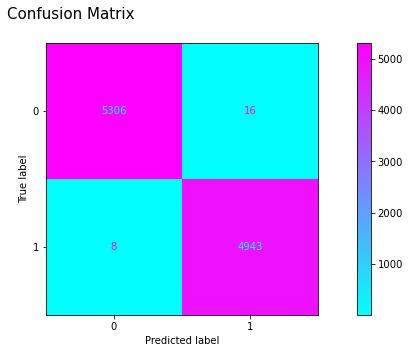

In [15]:
# Build Model with Best Hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train Model
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[callback])

# Evaluate Model on Test Data
pred = best_model.predict(X_test)
y_pred = np.argmax(pred, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['EfficientNetV2B0'] = results

## DenseNet121

In [16]:
# Define Tuner
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, DenseNet121),
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times each model is trained
    directory='tuning_results',  
    project_name='hyperparameter_tuning'
)

# Stop early if no improvement in 3 epochs
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[callback])

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: units={best_hps.get('units')}, dropout={best_hps.get('dropout')}, "
      f"optimizer={best_hps.get('optimizer')}, learning rate={best_hps.get('lr')}")

Reloading Tuner from tuning_results\hyperparameter_tuning\tuner0.json
Best Hyperparameters: units=64, dropout=0.2, optimizer=adam, learning rate=0.001


Epoch 1/20
899/899 [==============================] - 1771s 2s/step - loss: 0.4512 - accuracy: 0.7923 - val_loss: 0.3060 - val_accuracy: 0.8795
Epoch 2/20
899/899 [==============================] - 1770s 2s/step - loss: 0.2858 - accuracy: 0.8773 - val_loss: 0.2171 - val_accuracy: 0.9120
Epoch 3/20
899/899 [==============================] - 1742s 2s/step - loss: 0.2390 - accuracy: 0.9003 - val_loss: 0.1992 - val_accuracy: 0.9172
Epoch 4/20
899/899 [==============================] - 1752s 2s/step - loss: 0.2067 - accuracy: 0.9146 - val_loss: 0.1728 - val_accuracy: 0.9311
Epoch 5/20
899/899 [==============================] - 1752s 2s/step - loss: 0.1837 - accuracy: 0.9235 - val_loss: 0.1481 - val_accuracy: 0.9409
Epoch 6/20
899/899 [==============================] - 1754s 2s/step - loss: 0.1692 - accuracy: 0.9302 - val_loss: 0.1350 - val_accuracy: 0.9509
Epoch 7/20
899/899 [==============================] - 1750s 2s/step - loss: 0.1557 - accuracy: 0.9364 - val_loss: 0.1236 - val_accuracy:

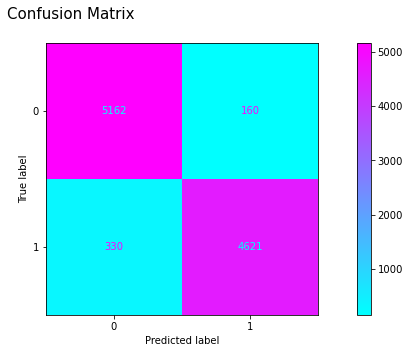

In [17]:
# Build Model with Best Hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train Model
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[callback])

# Evaluate Model on Test Data
pred = best_model.predict(X_test)
y_pred = np.argmax(pred, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['DenseNet121'] = results

##  ResNet50

In [ ]:
# Define Tuner
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, ResNet50),
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times each model is trained
    directory='tuning_results',  
    project_name='hyperparameter_tuning'
)

# Stop early if no improvement in 3 epochs
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[callback])

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: units={best_hps.get('units')}, dropout={best_hps.get('dropout')}, "
      f"optimizer={best_hps.get('optimizer')}, learning rate={best_hps.get('lr')}")

In [ ]:
# Build Model with Best Hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train Model
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[callback])

# Evaluate Model on Test Data
pred = best_model.predict(X_test)
y_pred = np.argmax(pred, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['ResNet50'] = results

## ResNet50V2 

In [18]:
# Define Tuner
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, ResNet50V2),
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times each model is trained
    directory='tuning_results',  
    project_name='hyperparameter_tuning'
)

# Stop early if no improvement in 3 epochs
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[callback])

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: units={best_hps.get('units')}, dropout={best_hps.get('dropout')}, "
      f"optimizer={best_hps.get('optimizer')}, learning rate={best_hps.get('lr')}")

Reloading Tuner from tuning_results\hyperparameter_tuning\tuner0.json
Best Hyperparameters: units=64, dropout=0.2, optimizer=adam, learning rate=0.001


Epoch 1/20
899/899 [==============================] - 1246s 1s/step - loss: 1.5486 - accuracy: 0.6502 - val_loss: 0.5142 - val_accuracy: 0.7364
Epoch 2/20
899/899 [==============================] - 1217s 1s/step - loss: 0.5790 - accuracy: 0.6689 - val_loss: 0.5048 - val_accuracy: 0.7854
Epoch 3/20
899/899 [==============================] - 1214s 1s/step - loss: 0.5474 - accuracy: 0.7216 - val_loss: 0.4945 - val_accuracy: 0.8069
Epoch 4/20
899/899 [==============================] - 1214s 1s/step - loss: 0.5409 - accuracy: 0.7279 - val_loss: 0.4371 - val_accuracy: 0.8271
Epoch 5/20
899/899 [==============================] - 1211s 1s/step - loss: 0.5220 - accuracy: 0.7434 - val_loss: 0.4336 - val_accuracy: 0.8345
Epoch 6/20
899/899 [==============================] - 1213s 1s/step - loss: 0.5077 - accuracy: 0.7530 - val_loss: 0.4162 - val_accuracy: 0.8391
Epoch 7/20
899/899 [==============================] - 1210s 1s/step - loss: 0.5054 - accuracy: 0.7557 - val_loss: 0.4210 - val_accuracy:

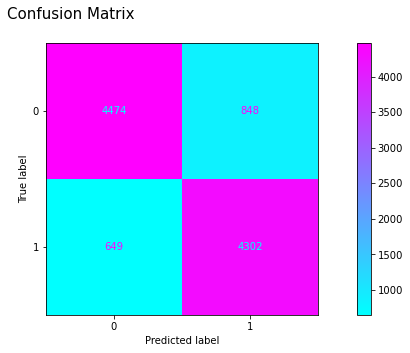

In [19]:
# Build Model with Best Hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train Model
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[callback])

# Evaluate Model on Test Data
pred = best_model.predict(X_test)
y_pred = np.argmax(pred, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['ResNet50V2'] = results

## InceptionV3

In [20]:
# Define Tuner
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, InceptionV3),
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times each model is trained
    directory='tuning_results',  
    project_name='hyperparameter_tuning'
)

# Stop early if no improvement in 3 epochs
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[callback])

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: units={best_hps.get('units')}, dropout={best_hps.get('dropout')}, "
      f"optimizer={best_hps.get('optimizer')}, learning rate={best_hps.get('lr')}")

Reloading Tuner from tuning_results\hyperparameter_tuning\tuner0.json
Best Hyperparameters: units=64, dropout=0.2, optimizer=adam, learning rate=0.001


Epoch 1/20
899/899 [==============================] - 705s 781ms/step - loss: 0.7396 - accuracy: 0.6536 - val_loss: 0.5280 - val_accuracy: 0.7584
Epoch 2/20
899/899 [==============================] - 695s 773ms/step - loss: 0.5322 - accuracy: 0.6980 - val_loss: 0.5198 - val_accuracy: 0.7452
Epoch 3/20
899/899 [==============================] - 701s 780ms/step - loss: 0.5058 - accuracy: 0.7178 - val_loss: 0.5944 - val_accuracy: 0.5850
Epoch 4/20
899/899 [==============================] - 699s 777ms/step - loss: 0.4870 - accuracy: 0.7290 - val_loss: 0.4266 - val_accuracy: 0.8161
Epoch 5/20
899/899 [==============================] - 696s 774ms/step - loss: 0.4770 - accuracy: 0.7376 - val_loss: 0.4079 - val_accuracy: 0.8188
Epoch 6/20
899/899 [==============================] - 697s 776ms/step - loss: 0.4690 - accuracy: 0.7403 - val_loss: 0.3968 - val_accuracy: 0.8226
Epoch 7/20
899/899 [==============================] - 700s 779ms/step - loss: 0.4678 - accuracy: 0.7361 - val_loss: 0.4052 -

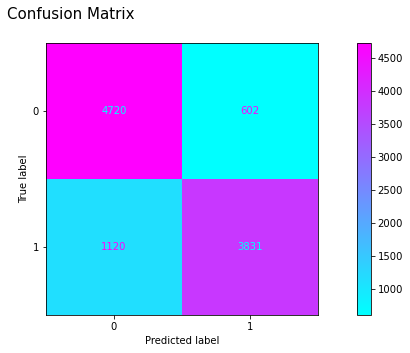

In [21]:
# Build Model with Best Hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train Model
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[callback])

# Evaluate Model on Test Data
pred = best_model.predict(X_test)
y_pred = np.argmax(pred, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['InceptionV3'] = results

## Xception 

In [22]:
# Define Tuner
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, Xception),
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times each model is trained
    directory='tuning_results',  
    project_name='hyperparameter_tuning'
)

# Stop early if no improvement in 3 epochs
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[callback])

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: units={best_hps.get('units')}, dropout={best_hps.get('dropout')}, "
      f"optimizer={best_hps.get('optimizer')}, learning rate={best_hps.get('lr')}")

Reloading Tuner from tuning_results\hyperparameter_tuning\tuner0.json
Best Hyperparameters: units=64, dropout=0.2, optimizer=adam, learning rate=0.001


Epoch 1/20
899/899 [==============================] - 1435s 2s/step - loss: 0.6756 - accuracy: 0.7391 - val_loss: 0.4407 - val_accuracy: 0.7909
Epoch 2/20
899/899 [==============================] - 1401s 2s/step - loss: 0.4308 - accuracy: 0.7986 - val_loss: 0.3950 - val_accuracy: 0.8237
Epoch 3/20
899/899 [==============================] - 1413s 2s/step - loss: 0.4025 - accuracy: 0.8132 - val_loss: 0.3454 - val_accuracy: 0.8490
Epoch 4/20
899/899 [==============================] - 1419s 2s/step - loss: 0.3792 - accuracy: 0.8202 - val_loss: 0.4104 - val_accuracy: 0.7968
Epoch 5/20
899/899 [==============================] - 1433s 2s/step - loss: 0.3678 - accuracy: 0.8331 - val_loss: 0.3543 - val_accuracy: 0.8344
Epoch 6/20
899/899 [==============================] - 1427s 2s/step - loss: 0.3555 - accuracy: 0.8360 - val_loss: 0.3257 - val_accuracy: 0.8615
Epoch 7/20
899/899 [==============================] - 1420s 2s/step - loss: 0.3324 - accuracy: 0.8473 - val_loss: 0.3254 - val_accuracy:

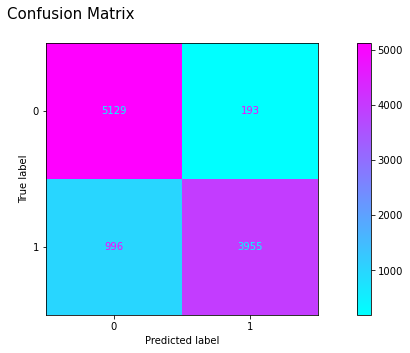

In [23]:
# Build Model with Best Hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train Model
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[callback])

# Evaluate Model on Test Data
pred = best_model.predict(X_test)
y_pred = np.argmax(pred, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['Xception'] = results

## InceptionResNetV2 

In [24]:
# Define Tuner
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, InceptionResNetV2),
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times each model is trained
    directory='tuning_results',  
    project_name='hyperparameter_tuning'
)

# Stop early if no improvement in 3 epochs
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[callback])

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: units={best_hps.get('units')}, dropout={best_hps.get('dropout')}, "
      f"optimizer={best_hps.get('optimizer')}, learning rate={best_hps.get('lr')}")

Reloading Tuner from tuning_results\hyperparameter_tuning\tuner0.json
Best Hyperparameters: units=64, dropout=0.2, optimizer=adam, learning rate=0.001


Epoch 1/20
899/899 [==============================] - 2596s 3s/step - loss: 2.0166 - accuracy: 0.5243 - val_loss: 0.6924 - val_accuracy: 0.5206
Epoch 2/20
899/899 [==============================] - 1867s 2s/step - loss: 0.6918 - accuracy: 0.5262 - val_loss: 0.6924 - val_accuracy: 0.5206
Epoch 3/20
899/899 [==============================] - 1850s 2s/step - loss: 0.6918 - accuracy: 0.5262 - val_loss: 0.6924 - val_accuracy: 0.5206
Epoch 4/20
899/899 [==============================] - 1842s 2s/step - loss: 0.6918 - accuracy: 0.5262 - val_loss: 0.6924 - val_accuracy: 0.5206
Epoch 5/20
899/899 [==============================] - 1840s 2s/step - loss: 0.6918 - accuracy: 0.5262 - val_loss: 0.6923 - val_accuracy: 0.5206
Epoch 6/20
899/899 [==============================] - 1853s 2s/step - loss: 0.6918 - accuracy: 0.5262 - val_loss: 0.6924 - val_accuracy: 0.5206
Epoch 7/20
899/899 [==============================] - 1852s 2s/step - loss: 0.6918 - accuracy: 0.5262 - val_loss: 0.6924 - val_accuracy:

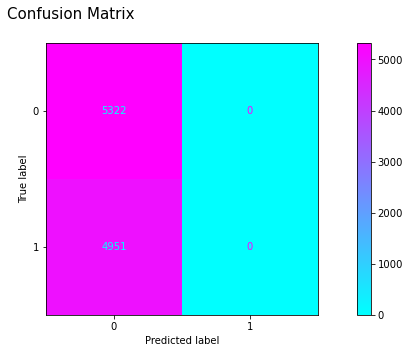

In [25]:
# Build Model with Best Hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train Model
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[callback])

# Evaluate Model on Test Data
pred = best_model.predict(X_test)
y_pred = np.argmax(pred, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['InceptionResNetV2'] = results

## VGG16 

In [ ]:
# Define Tuner
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, VGG16),
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times each model is trained
    directory='tuning_results',  
    project_name='hyperparameter_tuning'
)

# Stop early if no improvement in 3 epochs
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[callback])

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: units={best_hps.get('units')}, dropout={best_hps.get('dropout')}, "
      f"optimizer={best_hps.get('optimizer')}, learning rate={best_hps.get('lr')}")

In [ ]:
# Build Model with Best Hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train Model
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[callback])

# Evaluate Model on Test Data
pred = best_model.predict(X_test)
y_pred = np.argmax(pred, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['VGG16'] = results

## Model Results 

In [26]:
model_results.head(10)

,Metrics,MobileNetV3 Small,MobileNetV3 Large,EfficientNetV2B0,DenseNet121,ResNet50V2,InceptionV3,Xception,InceptionResNetV2
0,Accuracy,0.991434,0.997761,0.997664,0.952302,0.854278,0.832376,0.884260,0.518057
1,Precision,0.989925,0.998785,0.996774,0.966534,0.835340,0.864200,0.953472,0.000000
2,Recall,0.992325,0.996566,0.998384,0.933347,0.868915,0.773783,0.798829,0.000000
3,F1Score,0.991124,0.997675,0.997578,0.949651,0.851797,0.816496,0.869326,0.000000
4,ROC AUC,0.991465,0.997719,0.997689,0.951641,0.854788,0.830334,0.881282,0.500000


In [27]:
model_results.to_csv('../results/tuned_augmented_image_model_results.csv', index=True)